# Tutorial 4: P22 mouse brain section integration

To further demonstrate SMART’s advantages in computational efficiency and resource utilization for multi-omics integration, we evaluated its performance on one of the largest currently available spatial transcriptomics and epigenomics datasets. This dataset, obtained by CUT&Tag–RNA-seq, co-profiles transcriptomic data and H3K27me3 epigenetic marks in the P22 mouse brain, encompassing 9,752 spots, 25,881 genes, and 70,470 peaks, providing a robust benchmark for integrating transcriptomics and epigenomics.

The preprocessed data can be downloaded from: https://drive.google.com/drive/folders/1pIK6hZCvqHNh0K94-Lgy-CTyfixEUftQ?usp=drive_link.

## Load package

In [34]:
import os
import torch
import pandas as pd
import scanpy as sc
import warnings
import time
import sys
from muon import prot as pt
from muon import atac as ac
from smart.train import train_SMART
from smart.utils import set_seed
from smart.utils import pca
from smart.utils import clustering
from smart.build_graph import Cal_Spatial_Net
from smart.MNN import Mutual_Nearest_Neighbors
import matplotlib.pyplot as plt

set_seed(2025)

warnings.filterwarnings('ignore')
# Environment configuration. SMART pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path, use the command `R RHOME` to find the path.
os.environ['R_HOME'] = '/public/home/cit_wlhuang/.conda/envs/smart/lib/R'

## Load data

In [35]:
file_fold='../../../../SMART-main_orignal/datasets/Mouse_Brain_H3K27me3/'
adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics3 = sc.read_h5ad(file_fold + 'adata_ATAC.h5ad')

adata_omics1.var_names_make_unique()
adata_omics3.var_names_make_unique()

## Data pre-processing

In [ ]:
# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=30)

# ATAC
ac.pp.tfidf(adata_omics3, scale_factor=1e4)
sc.pp.normalize_per_cell(adata_omics3, counts_per_cell_after=1e4)
sc.pp.log1p(adata_omics3)
adata_omics3.obsm['feat'] = pca(adata_omics3, n_comps=50)

## Spatial neighbour graph construction

In [ ]:
Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=4)
Cal_Spatial_Net(adata_omics3, model="KNN", n_neighbors=4)

The graph contains 39008 edges, 9752 cells.
4.0000 neighbors per cell on average.
The graph contains 39008 edges, 9752 cells.
4.0000 neighbors per cell on average.


## MNN triplet samples calculation

In [ ]:
adata_list=[adata_omics1,adata_omics3]
x = [torch.FloatTensor(adata.obsm["feat"]).to(device) for adata in adata_list]
edges =[torch.LongTensor(adata.uns["edgeList"]).to(device) for adata in adata_list ]
triplet_samples_list = [Mutual_Nearest_Neighbors(adata, key="feat", n_nearest_neighbors=3,farthest_ratio=0.4) for adata in adata_list]

Distances calculation completed!
The data using feature 'feat' contains 7198 mnn_anchors
Distances calculation completed!
The data using feature 'feat' contains 1774 mnn_anchors


## Model training

In [ ]:
t1=time.time()
model=train_SMART(features=x, 
                  edges=edges,
                  triplet_samples_list=triplet_samples_list,
                  weights=[1,1,1,1],
                  emb_dim=64, 
                  n_epochs=500,
                  lr=0.005,
                  weight_decay=1e-5,
                  device = device,
                  window_size=10,
                  slope=0.0001)
adata_omics1.obsm["SMART"]=model(x, edges)[0].cpu().detach().numpy()
t2=time.time()
print(t2-t1)

  0%|          | 0/500 [00:00<?, ?it/s]

 40%|███▉      | 199/500 [00:16<00:24, 12.11it/s]


Early stopping: flat trend detected.
16.561851739883423


## Clustering

fitting ...
  |======================================================================| 100%


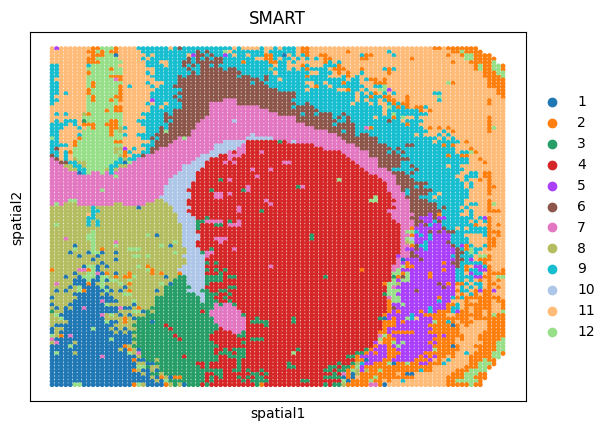

In [ ]:
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics1, key='SMART', add_key=f'SMART', n_clusters=12, method=tool, use_pca=True)
adata_omics1.obsm['spatial']=adata_omics1.obsm['spatial'][:,[1, 0]]
sc.pl.embedding(adata_omics1, basis='spatial', color="SMART",  s=50)

## Separate spatial plots of all clusters

In [ ]:
map_dict_12={
    1:"1-MS",
    2:"2-CTX",
    8:"3-LS",
    7:"4-CTX",
    3:"5-CP",
    5:"6-CTX",
    12:"7-CTX",
    6:"8-ccg/aco",    
    9:"9-VL",
    10:"10-CTX",
    11:"11-ACB",
    4:"12-ACA",
}

adata_omics1.obs["SMART_12_anno"]=adata_omics1.obs["SMART"].map(map_dict_12)

In [ ]:
map_dict_12.keys()

dict_keys([1, 2, 8, 7, 3, 5, 12, 6, 9, 10, 11, 4])

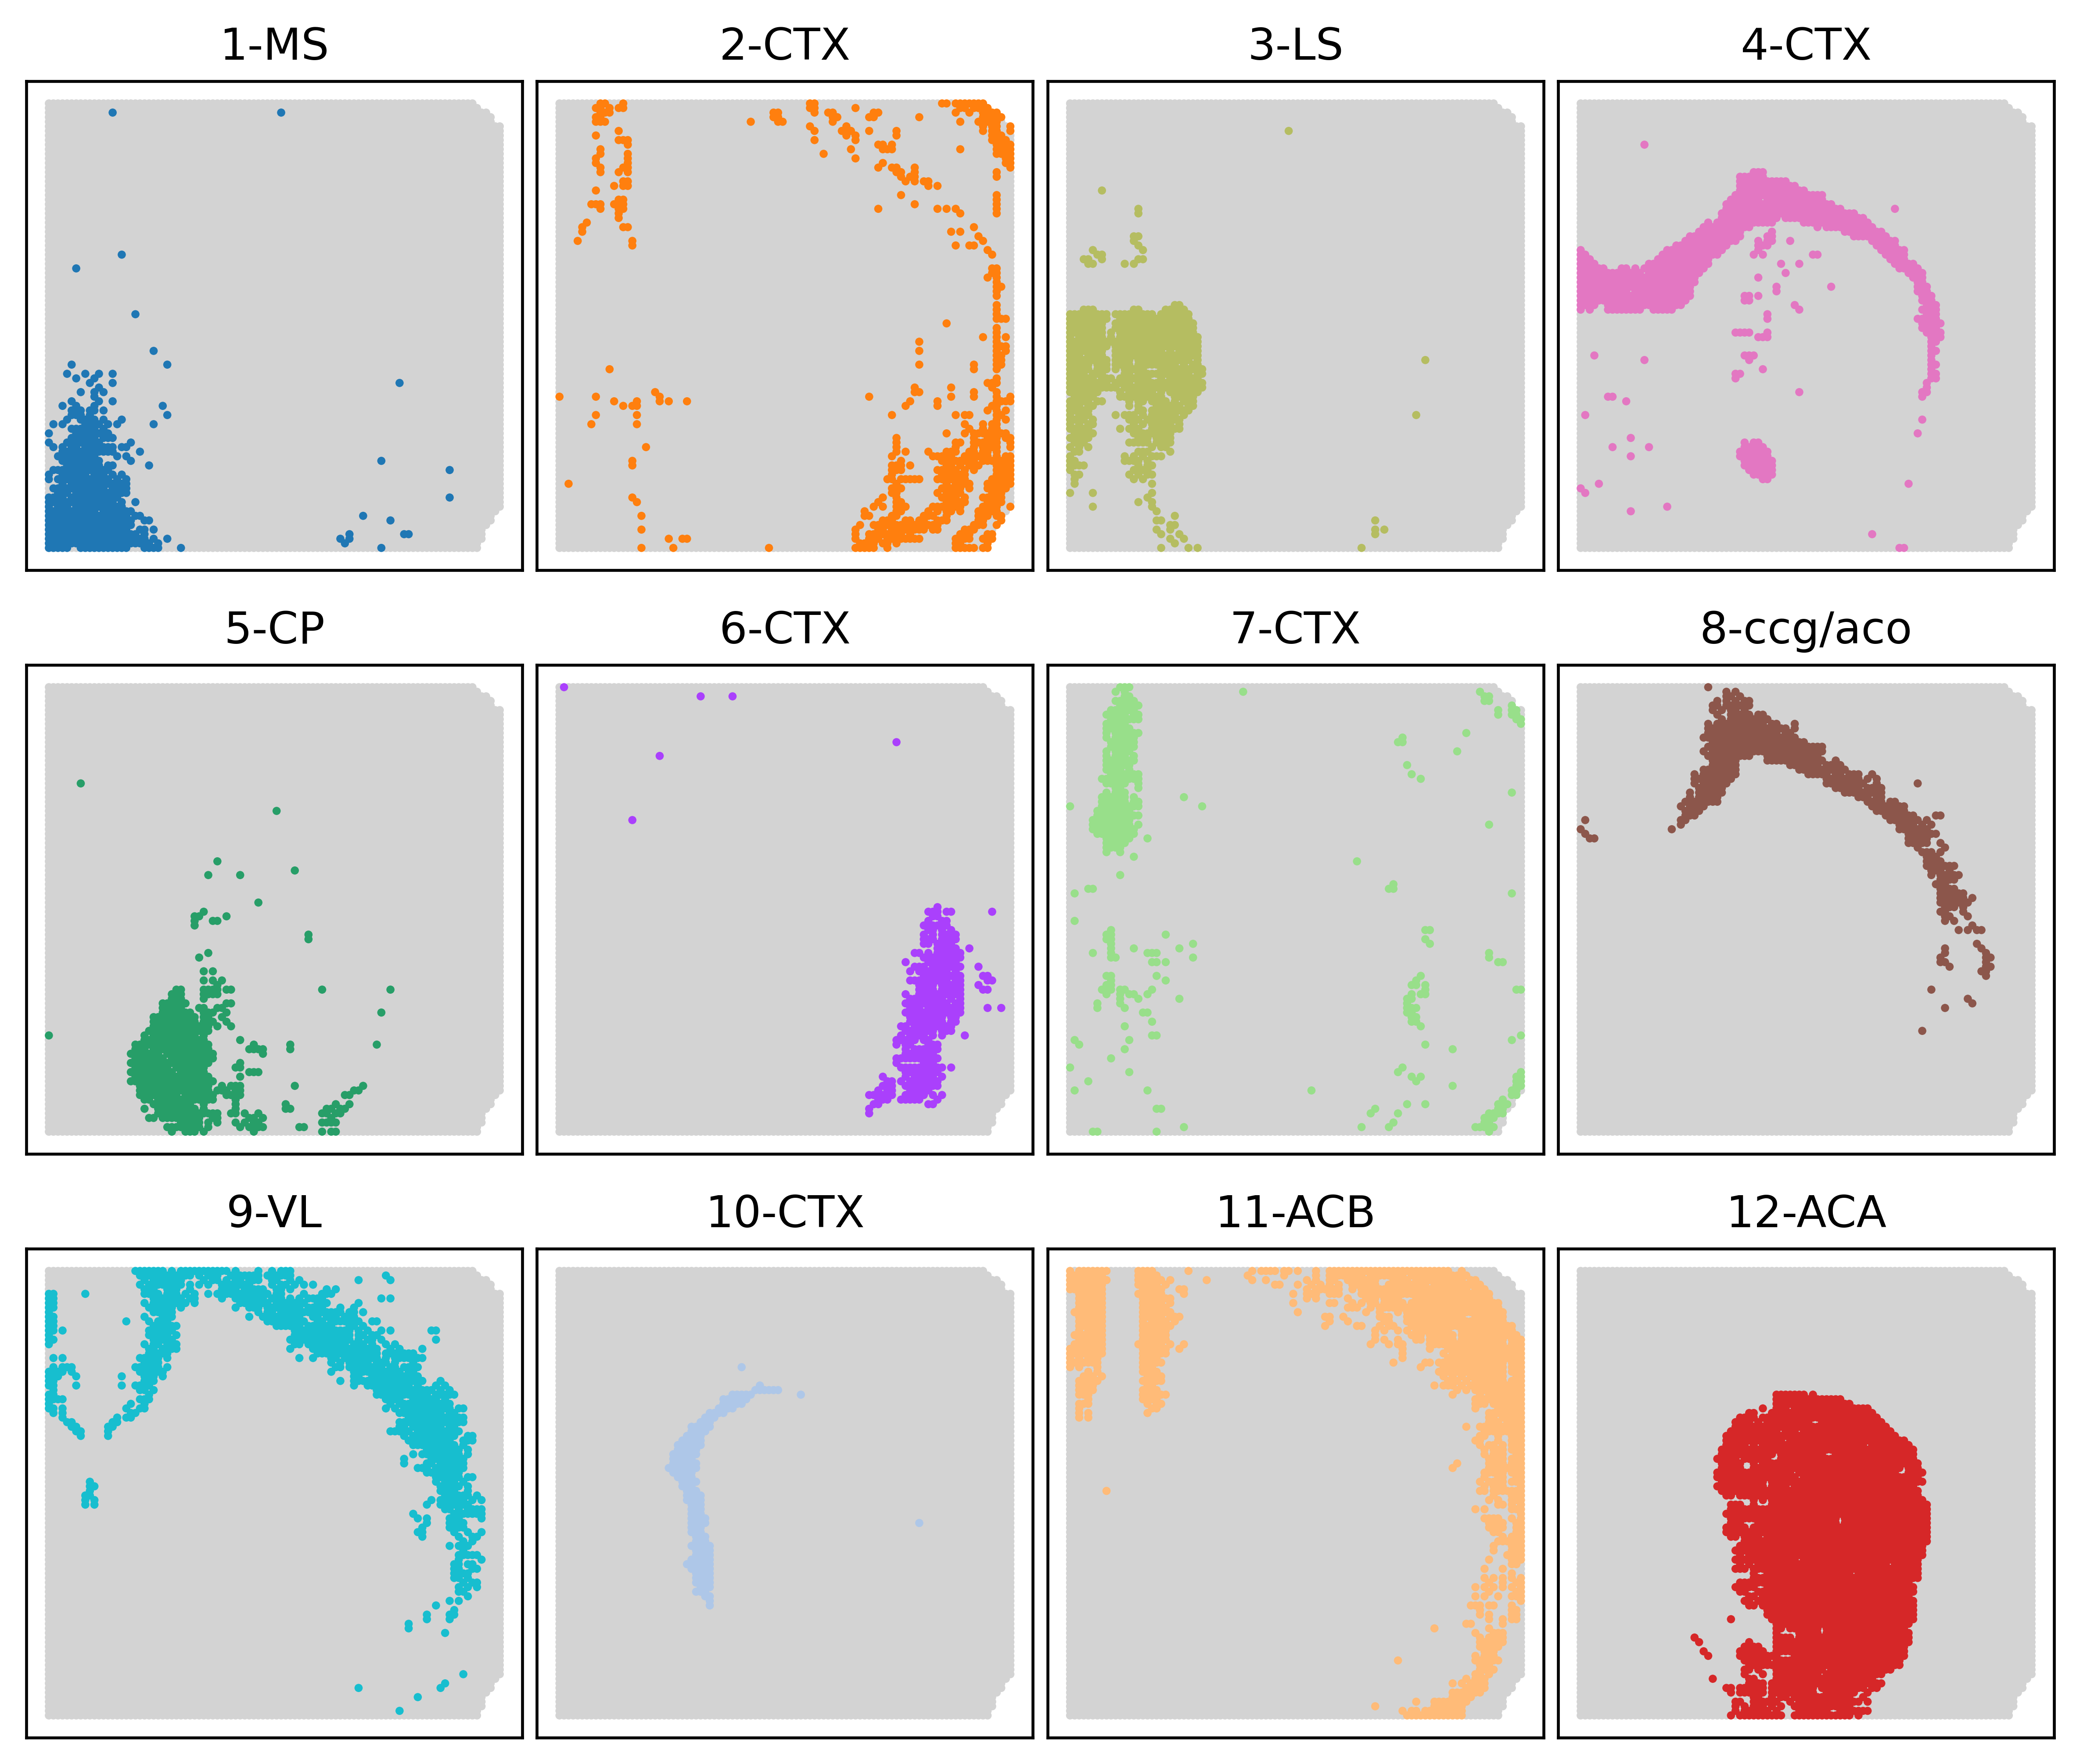

In [ ]:
fig, ax_list = plt.subplots(3, 4, figsize=(8, 6.8), dpi=600)

for idx, (cluster_id, cluster_name) in enumerate(map_dict_12.items()):
    row, col = divmod(idx, 4)
    sc.pl.embedding(
        adata_omics1,
        basis='spatial',
        color='SMART',
        groups=[cluster_id],  
        s=20,
        ax=ax_list[row][col],
        title=cluster_name,  
        show=False
    )
    ax_list[row][col].set_xlabel("")
    ax_list[row][col].set_ylabel("")
    ax_list[row][col].get_legend().remove()

plt.tight_layout(w_pad=0.4)
plt.show()